Expedia Stock market forecasting using RNN

#1. Importing the required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

‘yfinance’ is now a very popular library which is very python friendly and is used to download stock prices and also crypto prices 

In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#2. Load the Training Dataset.

Expedia training data has information from 21st July 2005 to 17 January 2023.

There are six columns:

The Open column tells the price at which a stock started trading when the market opened on a particular day. 

The Close column refers to the price of an individual stock when the stock exchange closed the market for the day.

The High column depicts the highest price at which a stock traded during a period. 

The Low column tells the lowest price of the period. 

Volume is the total amount of trading activity during a period of time.

Adjusted closing price refers to the price of the stock after paying off the dividends.


In [3]:
import yfinance as yf
expedia = yf.download("EXPD", start="2005-07-21", end="2023-01-17")
expedia.index=expedia.index.tz_localize(None)
print(expedia.info())

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4402 entries, 2005-07-21 to 2023-01-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4402 non-null   float64
 1   High       4402 non-null   float64
 2   Low        4402 non-null   float64
 3   Close      4402 non-null   float64
 4   Adj Close  4402 non-null   float64
 5   Volume     4402 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 240.7 KB
None


In [4]:
expedia.shape

(4402, 6)

In [5]:

expedia.index.min(), expedia.index.max()

(Timestamp('2005-07-21 00:00:00'), Timestamp('2023-01-13 00:00:00'))

In [6]:
expedia.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-07-21,27.379999,27.665001,27.094999,27.575001,22.536278,2443800
2005-07-22,27.465000,27.775000,27.445000,27.665001,22.609831,1155200
2005-07-25,27.639999,27.975000,27.375000,27.594999,22.552620,1812800
2005-07-26,27.600000,27.674999,27.275000,27.455000,22.438202,1523000
2005-07-27,27.575001,27.850000,27.315001,27.540001,22.507671,1402800


I chose to analyze high price for the period 2005-2023

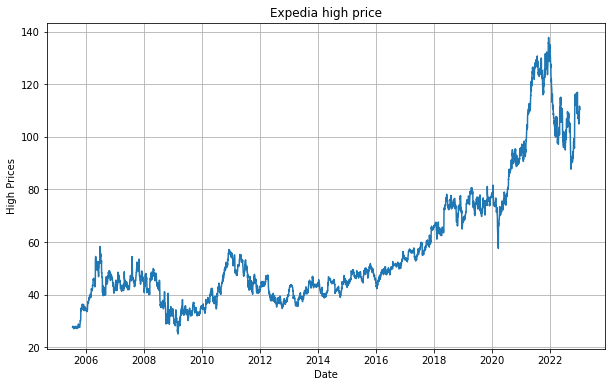

In [7]:
#plot high price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('High Prices')
plt.plot(expedia['High'])
plt.title('Expedia high price')
plt.show()

#3. Use the High Stock Price Column to Train Your Model.

In [8]:
tstart = 2005
tend = 2019

print(f'{tstart}')

2005


Train Set is : Pre Covid (2005-2020)

Test Set is : Post Covid(2020-2023)

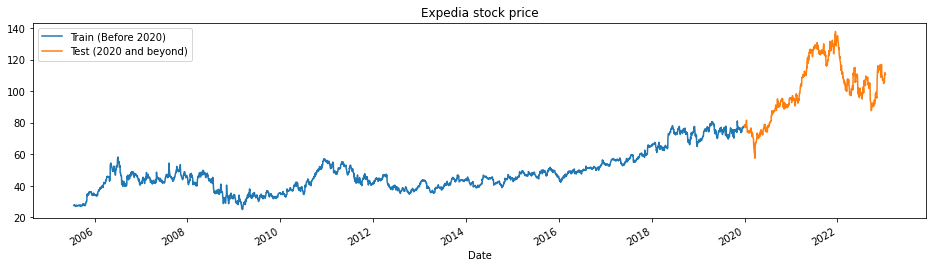

In [9]:

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Expedia stock price")
    plt.show()

train_test_plot(expedia,tstart,tend)

In [10]:
## Train and Test data split function
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(expedia, tstart, tend)

#4. Normalizing the Dataset.

In [11]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

#5. Creating X_train and y_train Data Structures.

In [12]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 30
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

We use the split_sequence function to create input/output pairs from the input sequence, where each input consists of the previous 30 stock prices and each output is the next stock price.

In [13]:
X_train.shape

(3607, 30, 1)

In [14]:
y_train.shape

(3607, 1)

In [15]:
## Printing the first record after sequencing
print(X_train[0])

## Number of input values in the each record
print("\n\nNumber of values in each record (features) :", len(X_train[0]))

[[0.04695296]
 [0.04891302]
 [0.05247683]
 [0.04713112]
 [0.05024946]
 [0.04739843]
 [0.04828936]
 [0.04668565]
 [0.03804348]
 [0.03857803]
 [0.03510334]
 [0.03545972]
 [0.03822164]
 [0.04526014]
 [0.0478439 ]
 [0.04971488]
 [0.04855664]
 [0.04526014]
 [0.04401282]
 [0.03937988]
 [0.04116179]
 [0.04125087]
 [0.04534925]
 [0.04624019]
 [0.04543833]
 [0.04552741]
 [0.04321096]
 [0.04365643]
 [0.0441019 ]
 [0.04855664]]


Number of values in each record (features) : 30


In [16]:
X_train.shape

(3607, 30, 1)

#6. Reshape the Data

Reshaping it to the format which is required by rnn models

In [17]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [18]:
X_train.shape #sample,time_steps,features

(3607, 30, 1)

In [19]:
X_train[0]

array([[0.04695296],
       [0.04891302],
       [0.05247683],
       [0.04713112],
       [0.05024946],
       [0.04739843],
       [0.04828936],
       [0.04668565],
       [0.03804348],
       [0.03857803],
       [0.03510334],
       [0.03545972],
       [0.03822164],
       [0.04526014],
       [0.0478439 ],
       [0.04971488],
       [0.04855664],
       [0.04526014],
       [0.04401282],
       [0.03937988],
       [0.04116179],
       [0.04125087],
       [0.04534925],
       [0.04624019],
       [0.04543833],
       [0.04552741],
       [0.04321096],
       [0.04365643],
       [0.0441019 ],
       [0.04855664]])

#7. Model Application

##1. LSTM Model

In [20]:
model_lstm = Sequential()

model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
model_lstm.add(LSTM(units=50, activation='tanh'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1, activation='linear'))

# Compiling the model
model_lstm.compile(optimizer="adam", loss="mse", metrics=['mse'])


In [21]:
## Fitting the model
model_lstm.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
113/113 [==============================] - 7s 7ms/step - loss: 0.0091 - mse: 0.0091
Epoch 2/25
113/113 [==============================] - 1s 7ms/step - loss: 0.0024 - mse: 0.0024
Epoch 3/25
113/113 [==============================] - 1s 7ms/step - loss: 0.0021 - mse: 0.0021
Epoch 4/25
113/113 [==============================] - 1s 8ms/step - loss: 0.0020 - mse: 0.0020
Epoch 5/25
113/113 [==============================] - 1s 7ms/step - loss: 0.0020 - mse: 0.0020
Epoch 6/25
113/113 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018
Epoch 7/25
113/113 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017
Epoch 8/25
113/113 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0016
Epoch 9/25
113/113 [==============================] - 1s 9ms/step - loss: 0.0017 - mse: 0.0017
Epoch 10/25
113/113 [==============================] - 1s 13ms/step - loss: 0.0014 - mse: 0.0014
Epoch 11/25
113/113 [===========================

In [22]:
dataset_total = expedia.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
print(type(input))

<class 'method'>


In [23]:
inputs[:5]

array([76.31999969, 76.05999756, 75.79000092, 75.58000183, 75.55000305])

In [24]:
inputs = inputs.reshape(-1, 1)

#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)

# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

#prediction
predicted_stock_price = model_lstm.predict(X_test)

#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

24/24 [==============================] - 1s 3ms/step


In [25]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("expedia Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("expedia Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

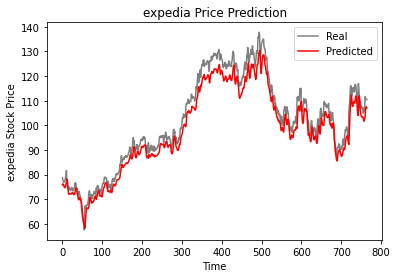

In [26]:
plot_predictions(test_set,predicted_stock_price)

In [27]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.39.


##2. Bidirectional LSTM Model

In [28]:
# Create bidirectional LSTM model
model_bid = Sequential()
model_bid.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh')))
model_bid.add(Bidirectional(LSTM(units=50, activation='tanh')))
model_bid.add(Dropout(0.2))
model_bid.add(Dense(units=1, activation='linear'))

# Compile bidirectional LSTM model
model_bid.compile(optimizer="adam", loss="mse", metrics=['mse'])

In [29]:
model_bid.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
113/113 [==============================] - 10s 11ms/step - loss: 0.0063 - mse: 0.0063
Epoch 2/25
113/113 [==============================] - 1s 11ms/step - loss: 0.0020 - mse: 0.0020
Epoch 3/25
113/113 [==============================] - 1s 11ms/step - loss: 0.0018 - mse: 0.0018
Epoch 4/25
113/113 [==============================] - 1s 11ms/step - loss: 0.0015 - mse: 0.0015
Epoch 5/25
113/113 [==============================] - 2s 14ms/step - loss: 0.0015 - mse: 0.0015
Epoch 6/25
113/113 [==============================] - 2s 19ms/step - loss: 0.0014 - mse: 0.0014
Epoch 7/25
113/113 [==============================] - 3s 23ms/step - loss: 0.0012 - mse: 0.0012
Epoch 8/25
113/113 [==============================] - 2s 19ms/step - loss: 0.0012 - mse: 0.0012
Epoch 9/25
113/113 [==============================] - 2s 19ms/step - loss: 0.0012 - mse: 0.0012
Epoch 10/25
113/113 [==============================] - 2s 19ms/step - loss: 0.0012 - mse: 0.0012
Epoch 11/25
113/113 [=================

24/24 [==============================] - 1s 4ms/step


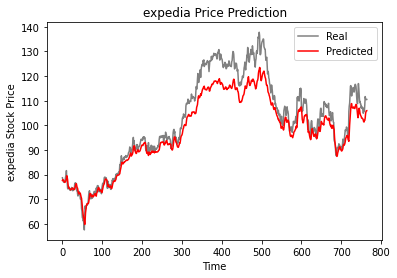

In [30]:
BID_predicted_stock_price = model_bid.predict(X_test)
BID_predicted_stock_price = sc.inverse_transform(BID_predicted_stock_price)
plot_predictions(test_set, BID_predicted_stock_price)

In [31]:
return_rmse(test_set,BID_predicted_stock_price)

The root mean squared error is 5.98.


##3. GRU Model

In [32]:
# Create GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
model_gru.add(GRU(units=50, activation='tanh'))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units=1, activation='linear'))

# Compile GRU model
model_gru.compile(optimizer="adam", loss="mse", metrics=['mse'])

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 50)            7950      
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_gru.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
113/113 [==============================] - 4s 6ms/step - loss: 0.0109 - mse: 0.0109
Epoch 2/25
113/113 [==============================] - 1s 8ms/step - loss: 0.0020 - mse: 0.0020
Epoch 3/25
113/113 [==============================] - 1s 8ms/step - loss: 0.0018 - mse: 0.0018
Epoch 4/25
113/113 [==============================] - 1s 9ms/step - loss: 0.0015 - mse: 0.0015
Epoch 5/25
113/113 [==============================] - 1s 7ms/step - loss: 0.0015 - mse: 0.0015
Epoch 6/25
113/113 [==============================] - 1s 7ms/step - loss: 0.0014 - mse: 0.0014
Epoch 7/25
113/113 [==============================] - 1s 6ms/step - loss: 0.0013 - mse: 0.0013
Epoch 8/25
113/113 [==============================] - 1s 6ms/step - loss: 0.0012 - mse: 0.0012
Epoch 9/25
113/113 [==============================] - 1s 6ms/step - loss: 0.0013 - mse: 0.0013
Epoch 10/25
113/113 [==============================] - 1s 6ms/step - loss: 0.0012 - mse: 0.0012
Epoch 11/25
113/113 [============================

24/24 [==============================] - 1s 3ms/step


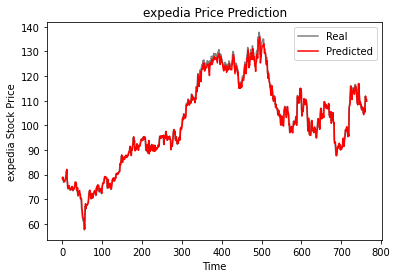

In [34]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [35]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 1.72.


GRU is the best model for my data, as it gives the lowest rmse